In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(SeuratDisk)
    library(ggpubr)
    library(tictoc)
    library(future)
    library(ComplexHeatmap)
    library(circlize)
    library("Nebulosa")
})

o <- function(w,h){
    options(repr.plot.width=w, repr.plot.height=h)
}

In [2]:
load("t.cd4.annot.rda")

ls()


[1] "o"     "t.cd4"

In [8]:
t.cd4[["fineLabel"]]<-paste(t.cd4@meta.data$CD4CD8, t.cd4@meta.data$CD4sub, sep=" ")

In [4]:
library(paletteer)  
cl_levels = unique(t.cd4@meta.data$organ)
blockcol = paletteer_d("ggsci::default_igv")[1:length(cl_levels)] %>% as.vector
names(blockcol) <-cl_levels
blockcol

Lung    Pancreas       Blood       Liver      Muscle      Thymus 
"#5050FFFF" "#CE3D32FF" "#749B58FF" "#F0E685FF" "#466983FF" "#BA6338FF" 
    Jejunum      Rectum       Colon      Kidney Gallbladder     Stomach 
"#5DB1DDFF" "#802268FF" "#6BD76BFF" "#D595A7FF" "#924822FF" "#837B8DFF" 
    Thyroid   Intestine      Spleen Bone marrow         Eye 
"#C75127FF" "#D58F5CFF" "#7A65A5FF" "#E4AF69FF" "#3B1B53FF"

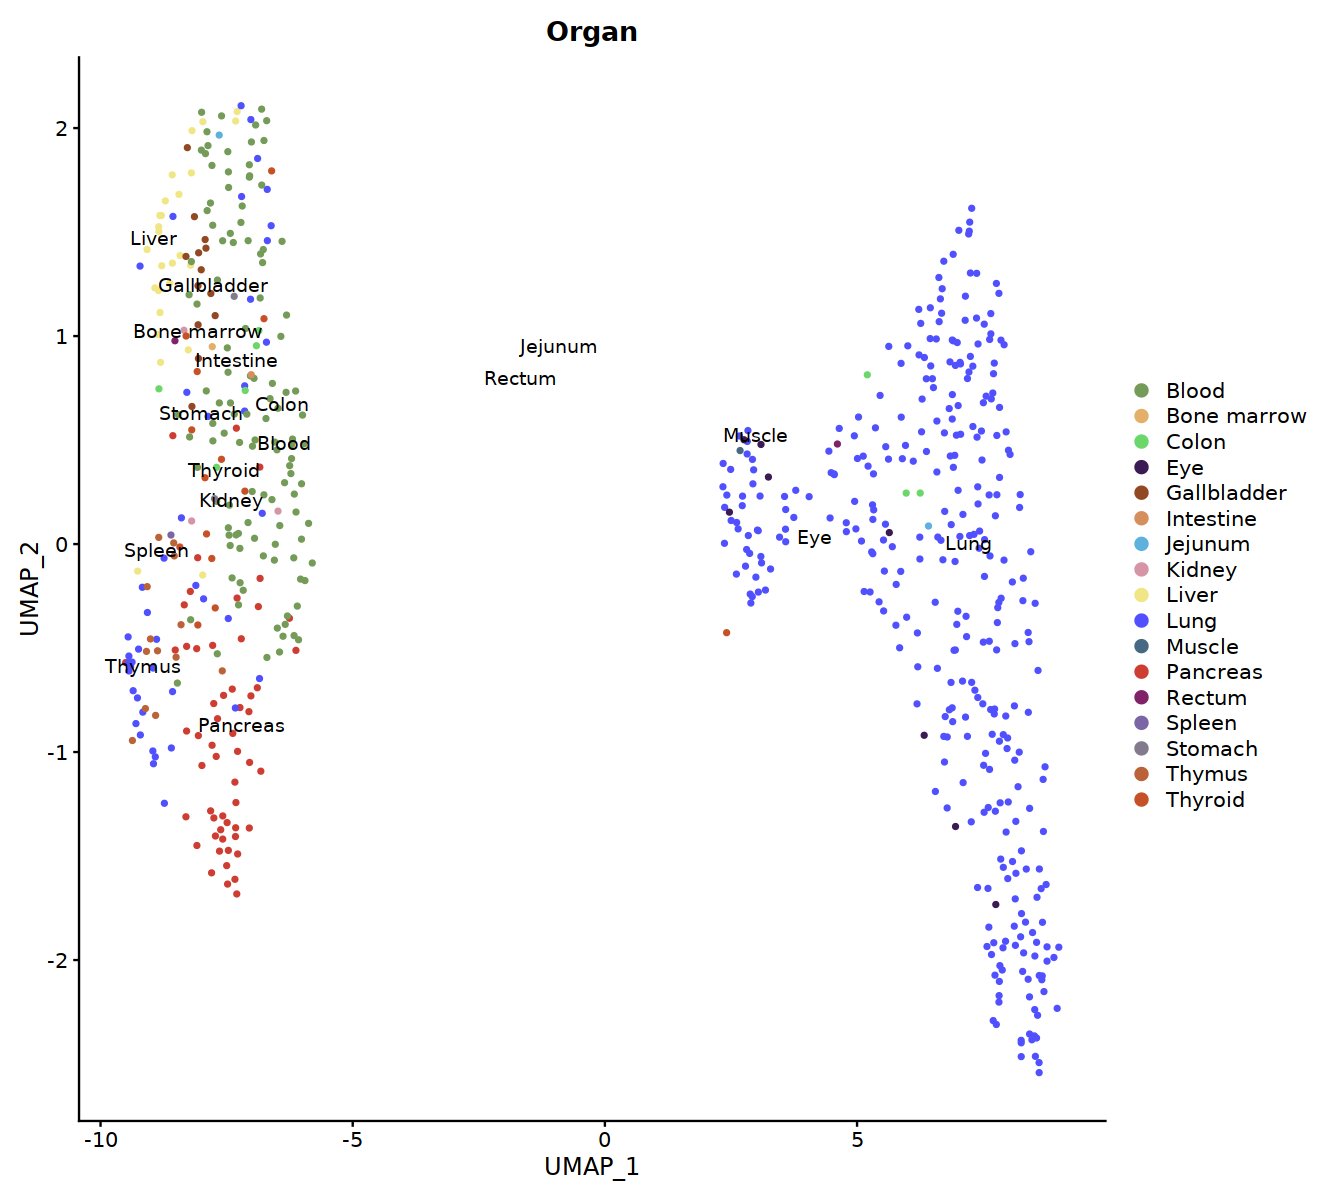

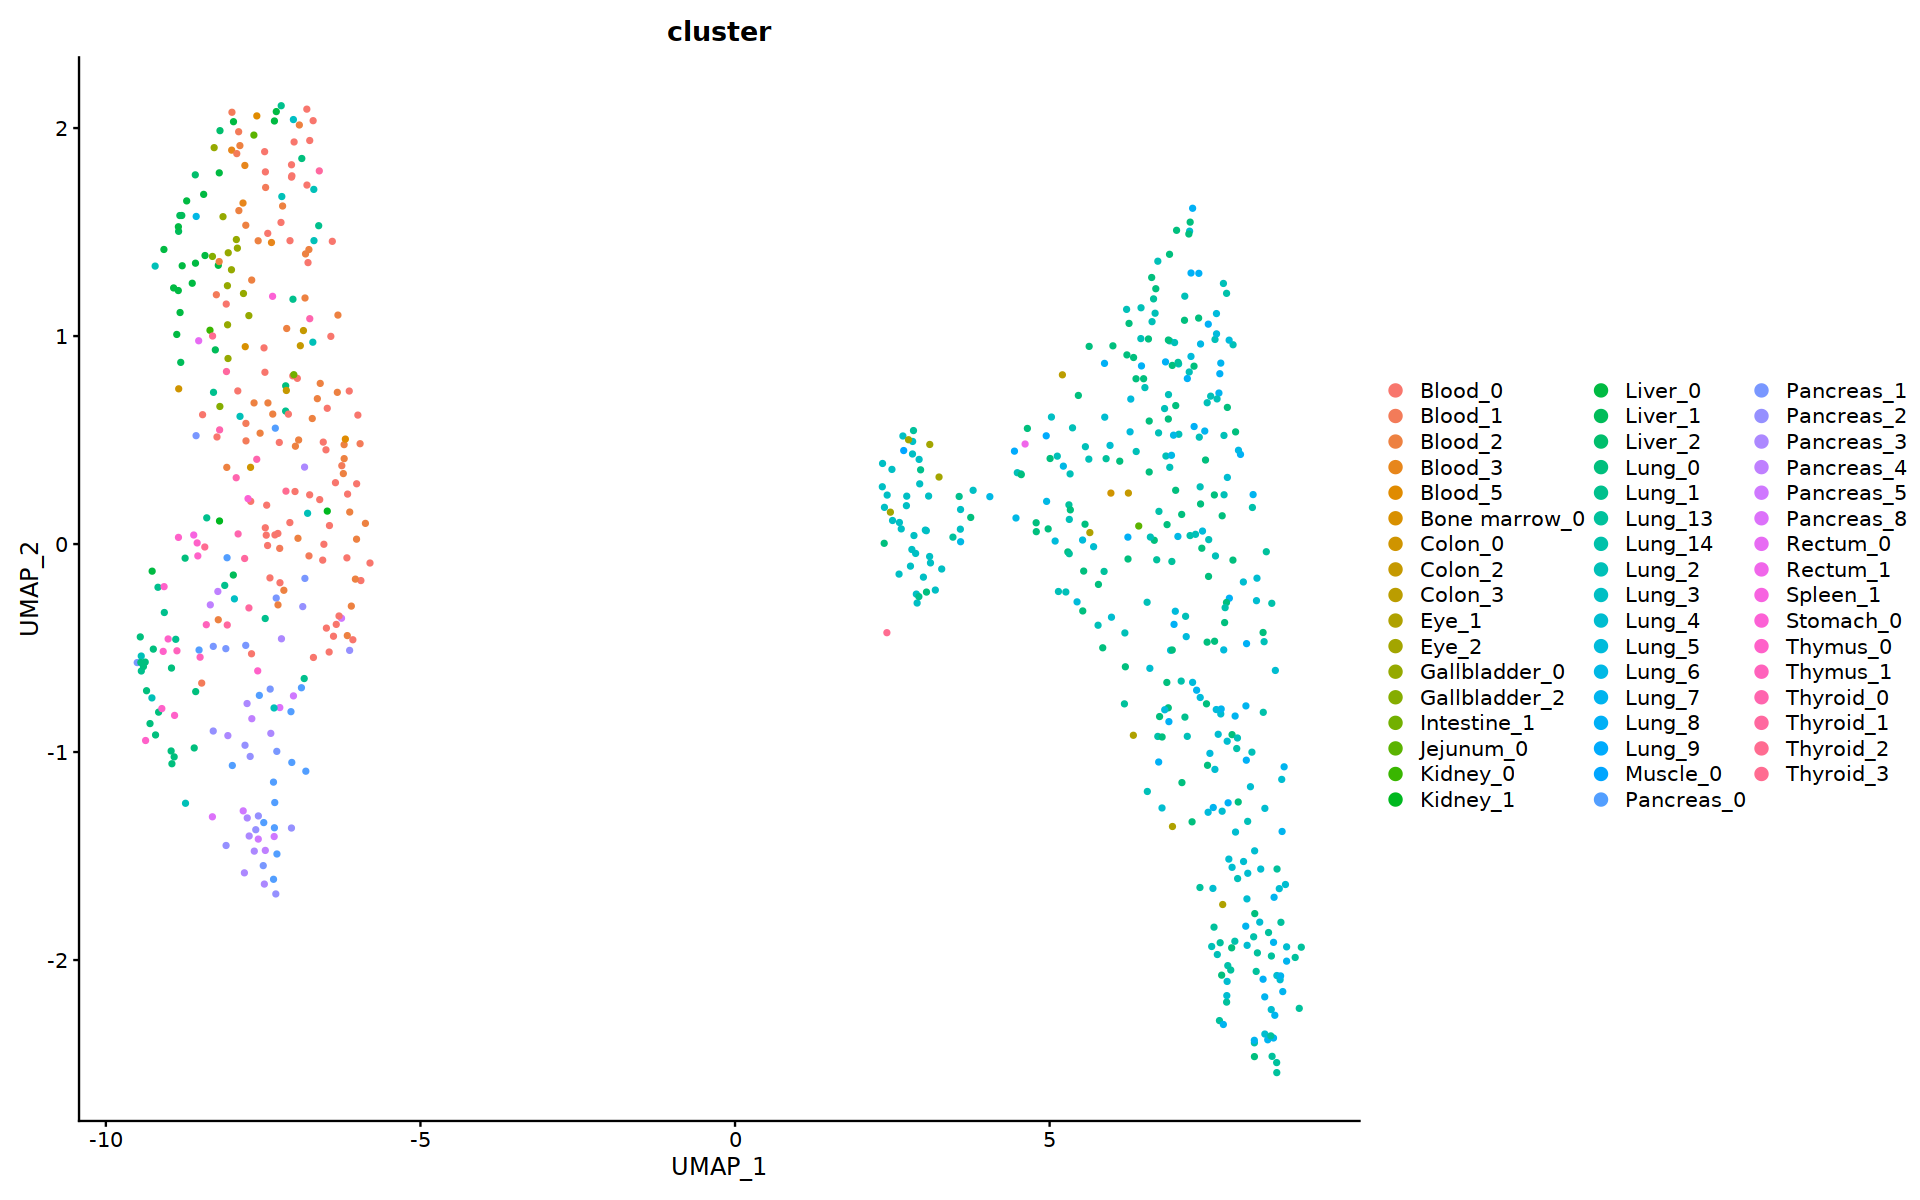

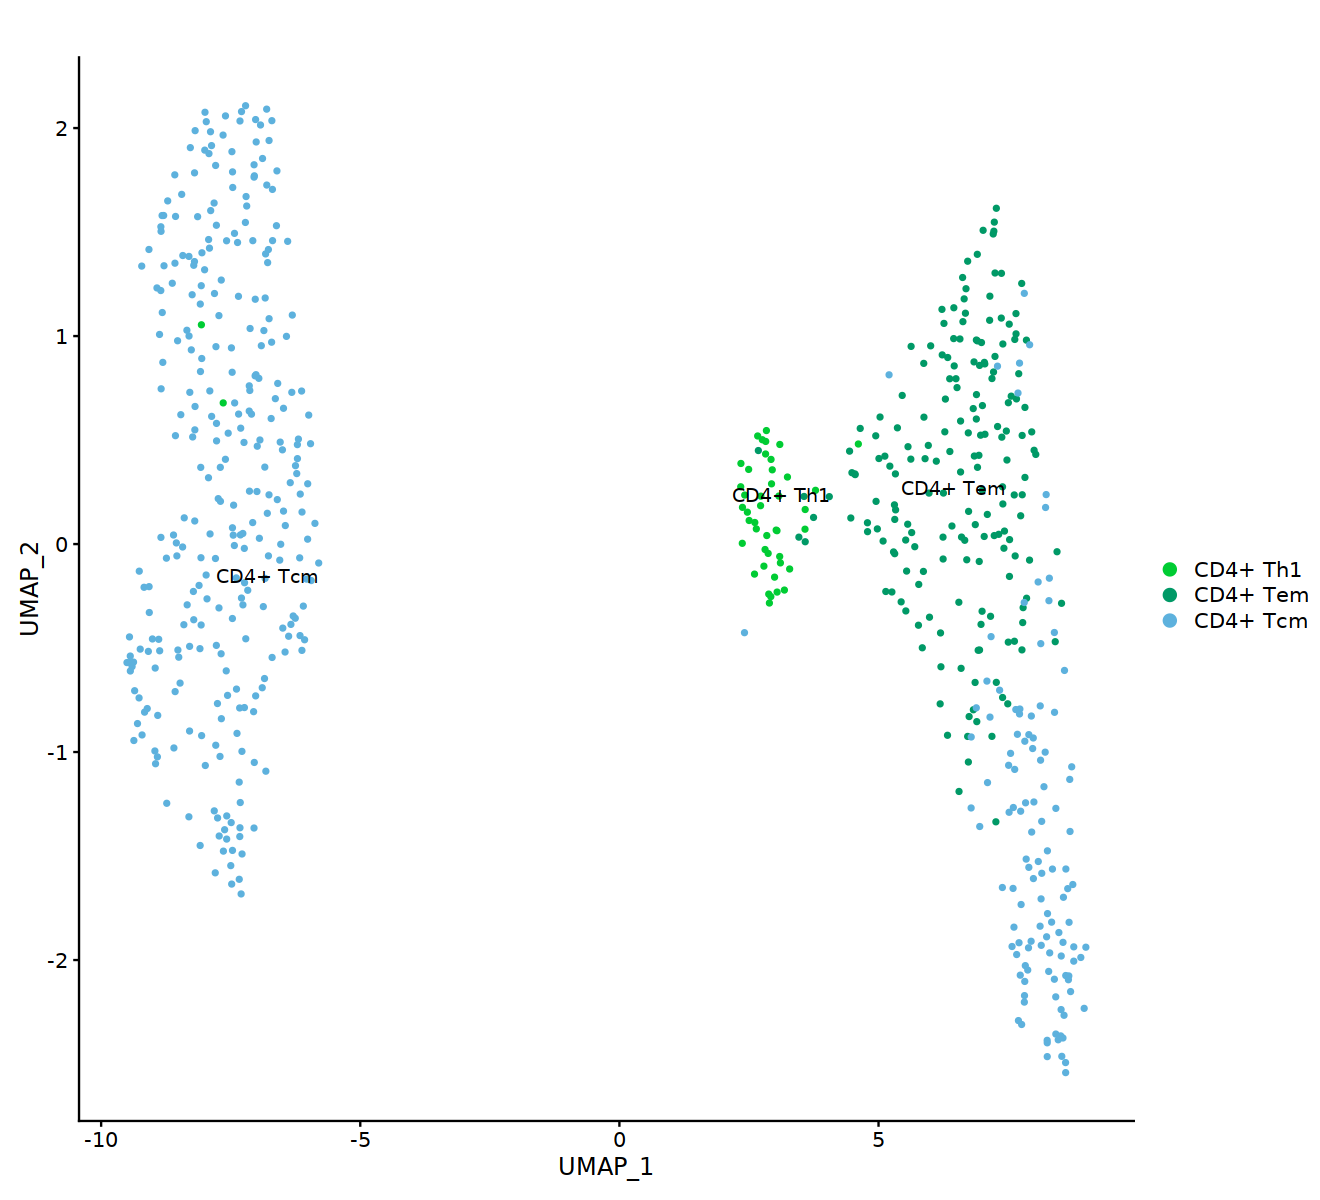

In [10]:
o(11,10)
DimPlot(t.cd4, group.by="organ", cols=blockcol, label=T,repel=T)+ggtitle("Organ")
o(16,10)
DimPlot(t.cd4, group.by="cluster")
o(10,10)
#DimPlot(subset(seu, fineLabel!="DN T"), group.by="fineLabel")
#DimPlot(subset(seu, fineLabel!="DN T"), group.by="CD4CD8")

o(11,10)
DimPlot(t.cd4, group.by="fineLabel", pt.size=1,
order=c( 'CD4+ Tcm',  'CD4+ Tem',  'CD4+ Th1',  'CD8+ Tcm',  'CD8+ Trm',  'CD8+ Tc','DN T' ),
cols = c('CD4+ Tcm'='#5DB1DDFF',
  'CD4+ Tem'='#009966FF',
  'CD4+ Th1'='#00CC33FF',
  'CD8+ Tcm'='#D60047FF',
  'CD8+ Trm'='#C75127FF',
  'CD8+ Tc' ='#660099FF',
  
  'DN T'    ='#A9A9A933'), label=T,repel=T)+ggtitle("")

# load metabolic genesets

In [12]:
library(AUCell)
library(GSVA)
library(GSEABase)
kegg.metabo <- getGmt("./KEGG_metabolism.gmt")
kegg.metabo.list = list()

for (i in 1:length(kegg.metabo)){
    gs_name=kegg.metabo[[i]]@setName
    gs_contents= kegg.metabo[[i]]@geneIds
    
    kegg.metabo.list[[gs_name]]=gs_contents
}

# construct per-cluster geneset

## per-cluster RNA object

In [13]:
Idents(t.cd4) <- "cluster"
t.cd4.avg <- AverageExpression(t.cd4, assays = "RNA", slot = "data", return.seurat=T)

Warning message:
“The following arguments are not used: row.names”
Centering and scaling data matrix



## per-cluster metabolism object

In [14]:
CreateGenesetScoreObject <- function(seu, gs.list, method, ...){
    if (method=="GSVA"){
        library(GSVA)
        gs.scores <- GSVA::gsva(expr=as.matrix(seu@assays$RNA@data), 
                                gset.idx.list = gs.list)
        gsva.seu <- CreateSeuratObject(counts = gs.scores[,rownames(seu@meta.data)], 
                    assay = "GSVA",
                    meta.data = seu@meta.data)
        
        gsva.seu@assays$GSVA@counts <- as.matrix(gsva.seu@assays$GSVA@counts)
        gsva.seu@assays$GSVA@data   <- as.matrix(gsva.seu@assays$GSVA@data)
        gsva.seu <- ScaleData(gsva.seu, assay="GSVA", do.scale=TRUE , do.center=TRUE)
        return(gsva.seu)
    }else if (method=="AUCell"){
        library(AUCell)
        cells_rankings <- AUCell_buildRankings(as.matrix(seu@assays$RNA@data))
        gs.scores <- AUCell_calcAUC(gs.list, cells_rankings, aucMaxRank=nrow(cells_rankings)*0.1)
        gs.scores <- getAUC(gs.scores)
        auc.seu <- CreateSeuratObject(counts = gs.scores[,rownames(seu@meta.data)], 
                    assay = "AUCell",
                    meta.data = seu@meta.data)
        
        auc.seu@assays$AUCell@counts <- as.matrix(auc.seu@assays$AUCell@counts)
        auc.seu@assays$AUCell@data   <- as.matrix(auc.seu@assays$AUCell@data)
        auc.seu <- ScaleData(auc.seu, assay="AUCell", do.scale=TRUE , do.center=TRUE)
        return(auc.seu)
    }else{
        message("undefined method")
        return
    }
    
}

In [15]:
t.cd4.avg.metabo<-CreateGenesetScoreObject(t.cd4.avg, gs.list =kegg.metabo.list, method="GSVA" )

Warning message in .filterFeatures(expr, method):
“30526 genes with constant expression values throuhgout the samples.”
Warning message in .filterFeatures(expr, method):
“Since argument method!="ssgsea", genes with constant expression values are discarded.”


Estimating GSVA scores for 83 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



Warning message:
“The following arguments are not used: row.names”
Centering and scaling data matrix



In [16]:
t.cd4.avg.metabo

An object of class Seurat 
83 features across 50 samples within 1 assay 
Active assay: GSVA (83 features, 0 variable features)

# Metabolic clustering

In [22]:
# 1.1 收集表达矩阵
mat  = t.cd4.avg.metabo@assays$GSVA@scale.data

# 1.2 把细胞按某种想要的顺序排好
ordered.cells <- colnames(mat)

# 1.3 选择一列感兴趣的基因用于绘图
t.cd4.avg.metabo<-FindVariableFeatures(t.cd4.avg.metabo,nfeatures = 30)
features.sel <-  VariableFeatures(t.cd4.avg.metabo) #rownames(mat)

# 1.4 重新组织原始矩阵按行列
mat = as.matrix( mat[features.sel, ordered.cells] )

meta = t.cd4.avg.metabo@meta.data

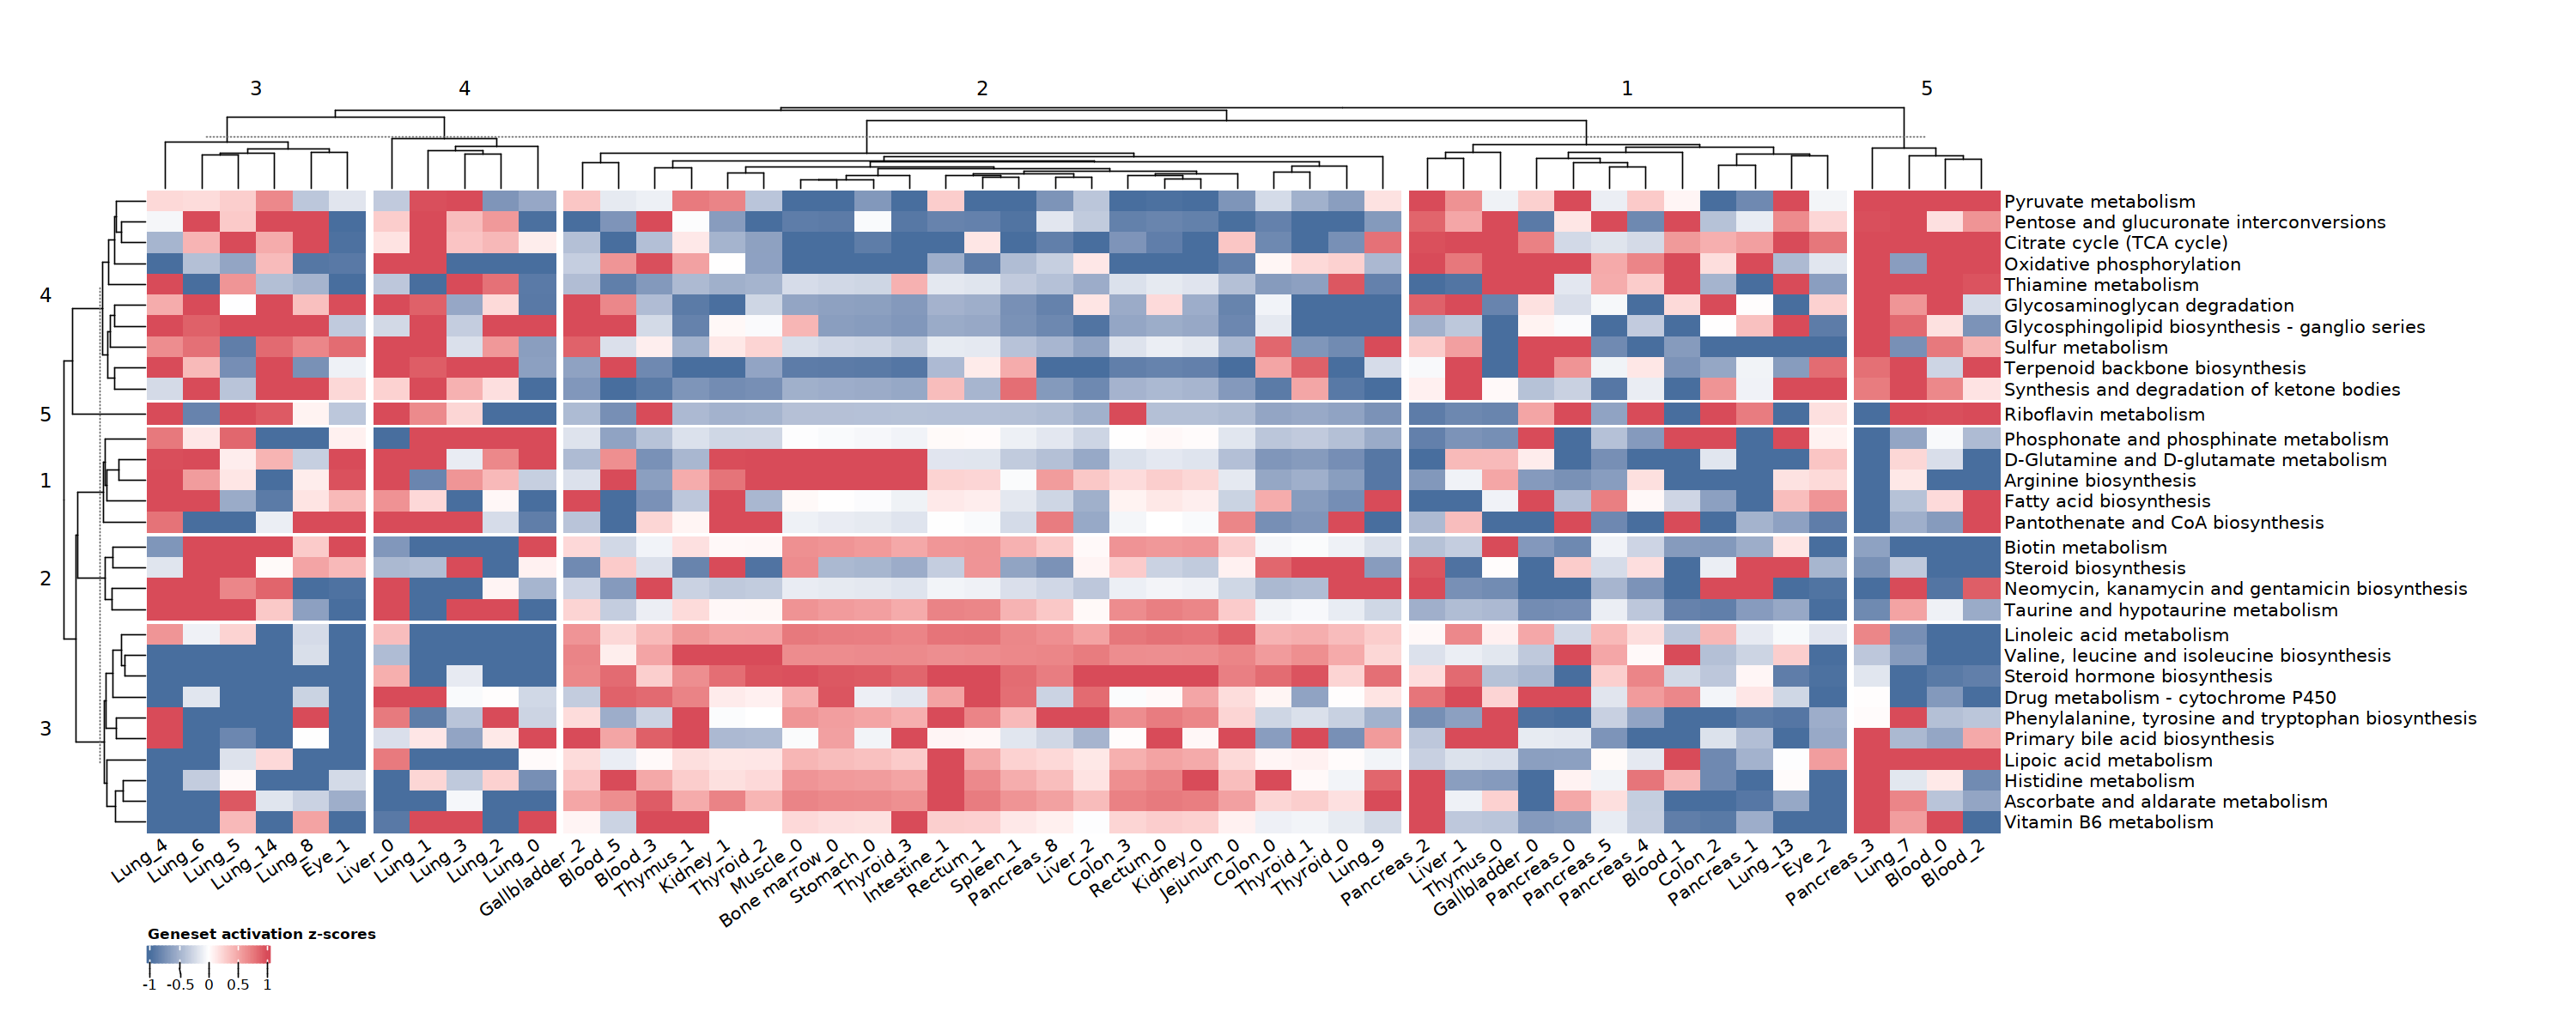

In [24]:
hm<-Heatmap(mat, name = "Geneset activation z-scores", 
        cluster_rows = T, cluster_columns = T, 
        show_column_names=T,
        column_dend_height = unit(2, "cm"), row_dend_width=unit(2,'cm'),
        row_km=5, column_km=5, column_km_repeats=100,row_km_repeats=100,
        cluster_column_slices=T, cluster_row_slices=T,
        #column_split=meta$organ, cluster_column_slices=T,
        col= colorRamp2(c(-1,0,1), c("#486E9E", "white", "#D84B59")),
        column_title_rot=0, row_title_rot=0, 
        column_names_rot =35,
        column_gap=unit(2, "mm"),
        #top_annotation=colann, 
        heatmap_legend_param = list(direction = "horizontal"),
        use_raster = F)

options(warn=-1)
options(repr.plot.width=25, repr.plot.height=10)
#cairo_pdf("t.metabo.hm.pdf",width=25, height = 20)
draw(hm,
     padding = unit(c(10, 10, 20, 80), "mm"), #下左上右
     merge_legend = TRUE,
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")
#dev.off()

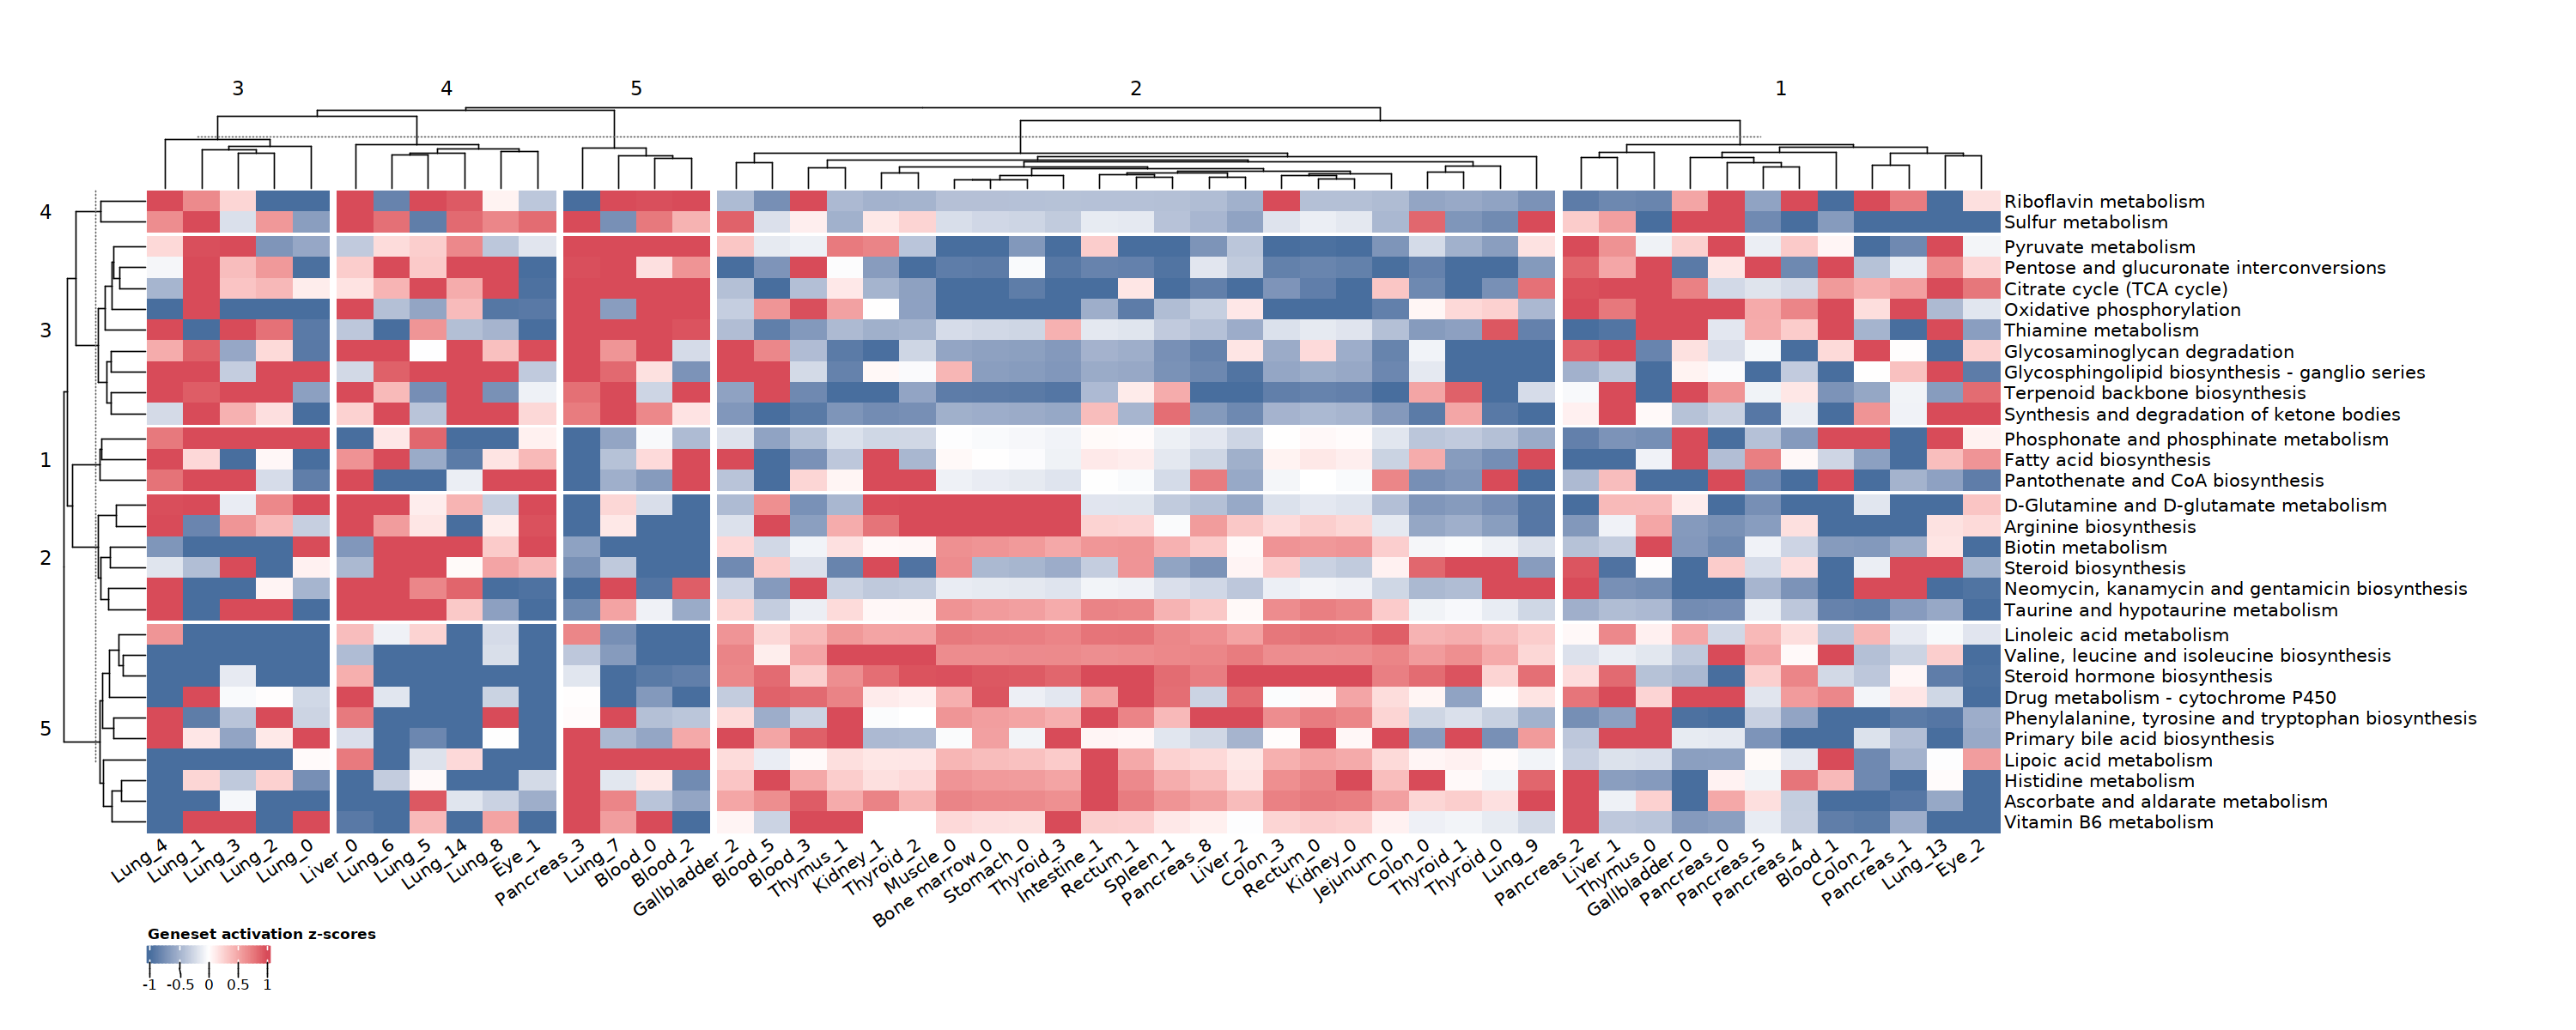

In [33]:
hm<-Heatmap(mat, name = "Geneset activation z-scores", 
        cluster_rows = T, cluster_columns = T, 
        show_column_names=T,
        column_dend_height = unit(2, "cm"), row_dend_width=unit(2,'cm'),
        row_km=5, column_km=5, column_km_repeats=100,row_km_repeats=100,
        cluster_column_slices=T, cluster_row_slices=T,
        #column_split=meta$organ, cluster_column_slices=T,
        col= colorRamp2(c(-1,0,1), c("#486E9E", "white", "#D84B59")),
        column_title_rot=0, row_title_rot=0, 
        column_names_rot =35,
        column_gap=unit(2, "mm"),
        #top_annotation=colann, 
        heatmap_legend_param = list(direction = "horizontal"),
        use_raster = F)

options(warn=-1)
options(repr.plot.width=25, repr.plot.height=10)
#cairo_pdf("t.metabo.hm.pdf",width=25, height = 20)
draw(hm,
     padding = unit(c(10, 10, 20, 80), "mm"), #下左上右
     merge_legend = TRUE,
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")
#dev.off()

In [34]:
hm<-Heatmap(mat, name = "Geneset activation z-scores", 
        cluster_rows = T, cluster_columns = T, 
        show_column_names=T,
        column_dend_height = unit(2, "cm"), row_dend_width=unit(2,'cm'),
        row_km=5, column_km=5, column_km_repeats=100,row_km_repeats=100,
        cluster_column_slices=T, cluster_row_slices=T,
        #column_split=meta$organ, cluster_column_slices=T,
        col= colorRamp2(c(-1,0,1), c("#486E9E", "white", "#D84B59")),
        column_title_rot=0, row_title_rot=0, 
        column_names_rot =35,
        column_gap=unit(2, "mm"),
        #top_annotation=colann, 
        heatmap_legend_param = list(direction = "horizontal"),
        use_raster = F)

options(warn=-1)
#options(repr.plot.width=25, repr.plot.height=10)
cairo_pdf("CD4T.metabo.per-cluster-hm.pdf",width=25, height = 10)
draw(hm,
     padding = unit(c(10, 10, 20, 80), "mm"), #下左上右
     merge_legend = TRUE,
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")
dev.off()

png 
  2

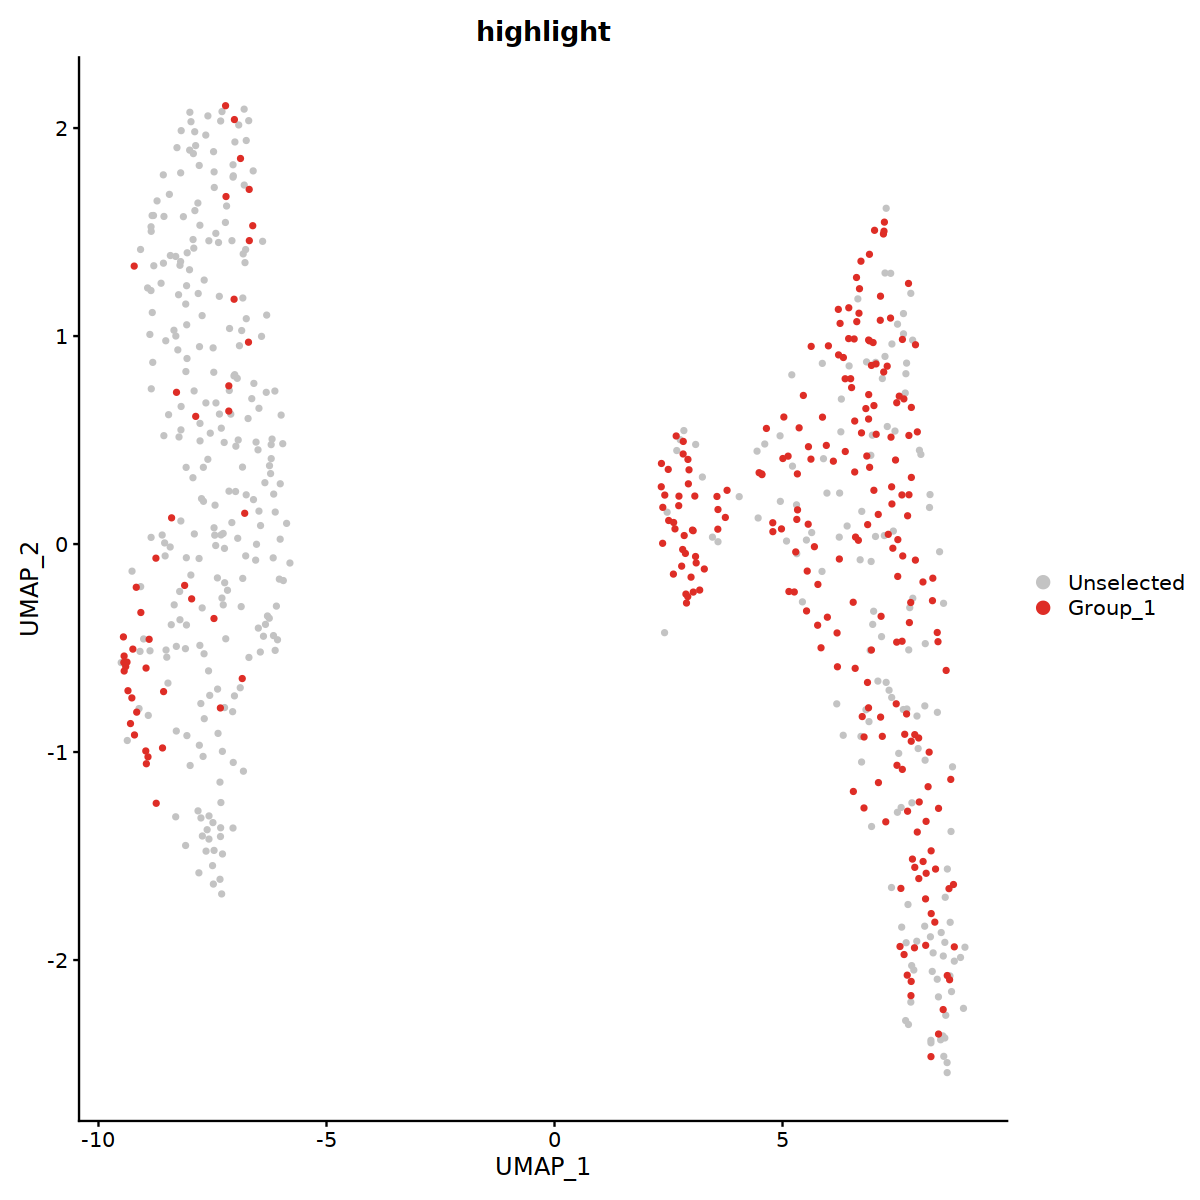

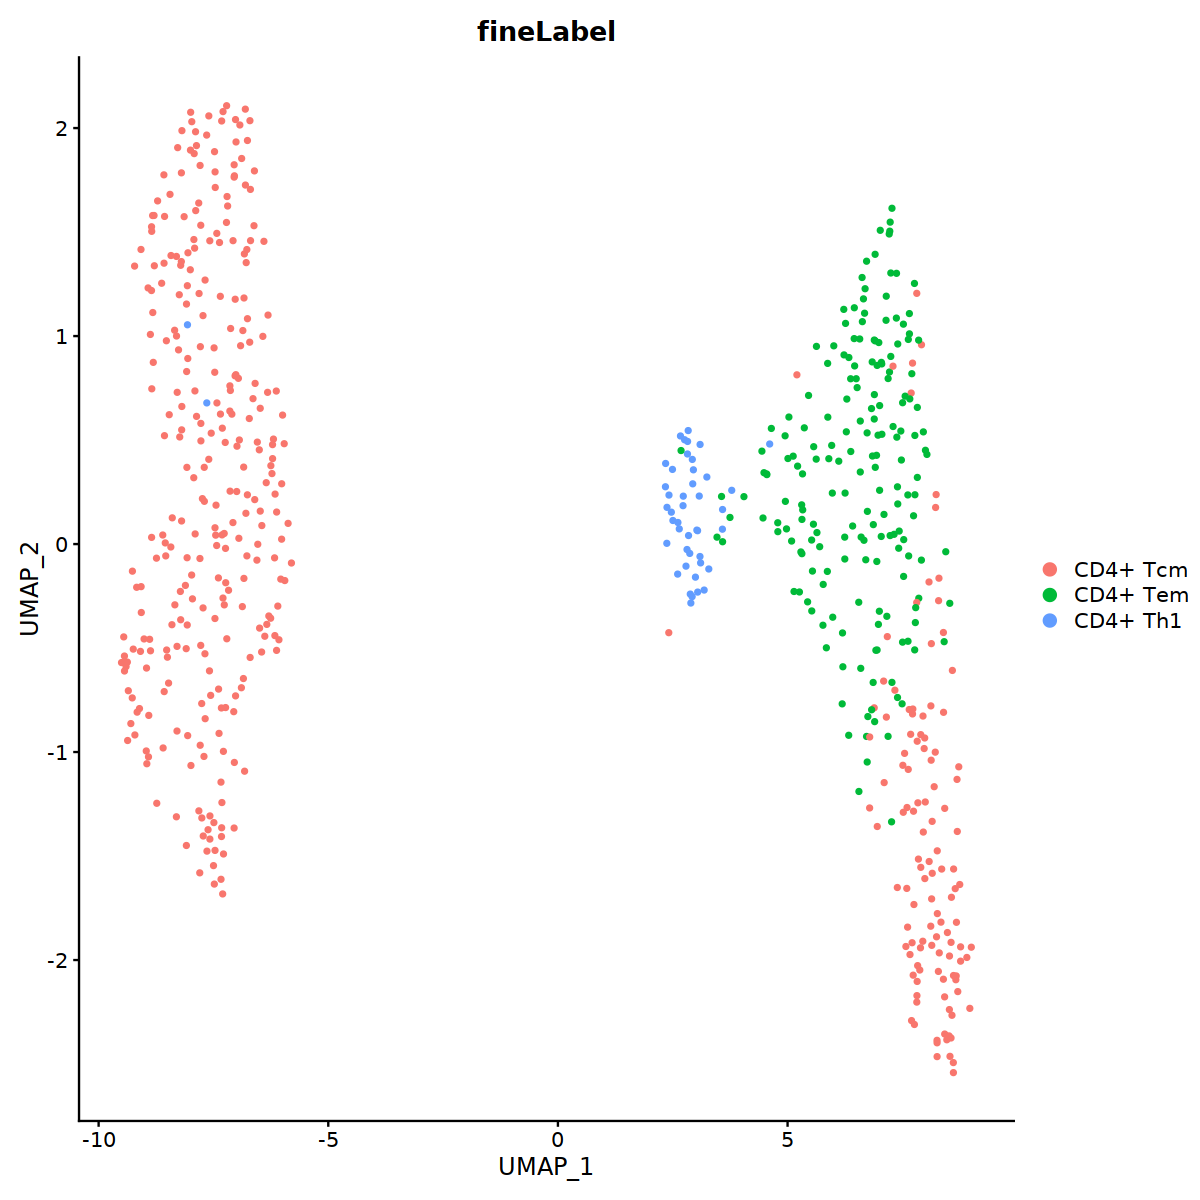

In [32]:
clusters.oi <- colnames(mat)[column_order(hm)[["3"]]]

o(10,10)
Idents(t.cd4 )<-"cluster"
DimPlot(t.cd4, group.by="cluster",
        cells.highlight=WhichCells(t.cd4, ident=clusters.oi))

DimPlot(t.cd4, group.by="fineLabel")